In [5]:
from backtesting.test import EURUSD, SMA

data = EURUSD.copy()
data

,Open,High,Low,Close,Volume
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554
...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065


In [7]:
def BBANDS(data, n_lookback, n_std):
    """ Bollinger bands indicator """
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [10]:
data.tail()

,Open,High,Low,Close,Volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203.0,-0.001970,-0.002386,-0.002976,-0.006345,-0.000416,-0.000590,-0.003369,-0.000040,0.004715,0.000050,0.004666,1.0,2.0,11.0
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325.0,-0.002280,-0.002871,-0.003423,-0.006920,-0.000591,-0.000552,-0.003496,0.000259,0.005591,0.000244,0.005347,1.0,2.0,12.0
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824.0,-0.002291,-0.003059,-0.003651,-0.007239,-0.000768,-0.000592,-0.003589,-0.001045,0.006103,0.000132,0.005971,1.0,2.0,13.0
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065.0,-0.001483,-0.002393,-0.003053,-0.006728,-0.000909,-0.000660,-0.003675,0.000032,0.005613,-0.000739,0.006351,1.0,2.0,14.0
2018-02-07 15:00:00,1.23427,1.23444,1.22904,1.22904,6143.0,-0.004919,-0.006238,-0.007073,-0.010884,-0.001319,-0.000835,-0.003810,-0.003793,0.010216,0.002492,0.007724,1.0,2.0,15.0


In [12]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.4211190576356752


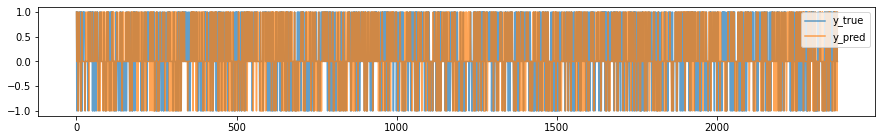

In [15]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))